Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=1000, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time= 5.9min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=1000, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=10.7min
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=10, min_child_weight=10, n_estimators=500, reg_alpha=0, reg_lambda=10, subsample=0.8; total time= 3.2min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time= 3.9min
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=1000, reg_alpha=0.01, reg_lambda=0, subsample=0.9; total time= 7.2min
[CV] END colsample_bytree=0.9, gamma=1, learning_rate=0.1, ma

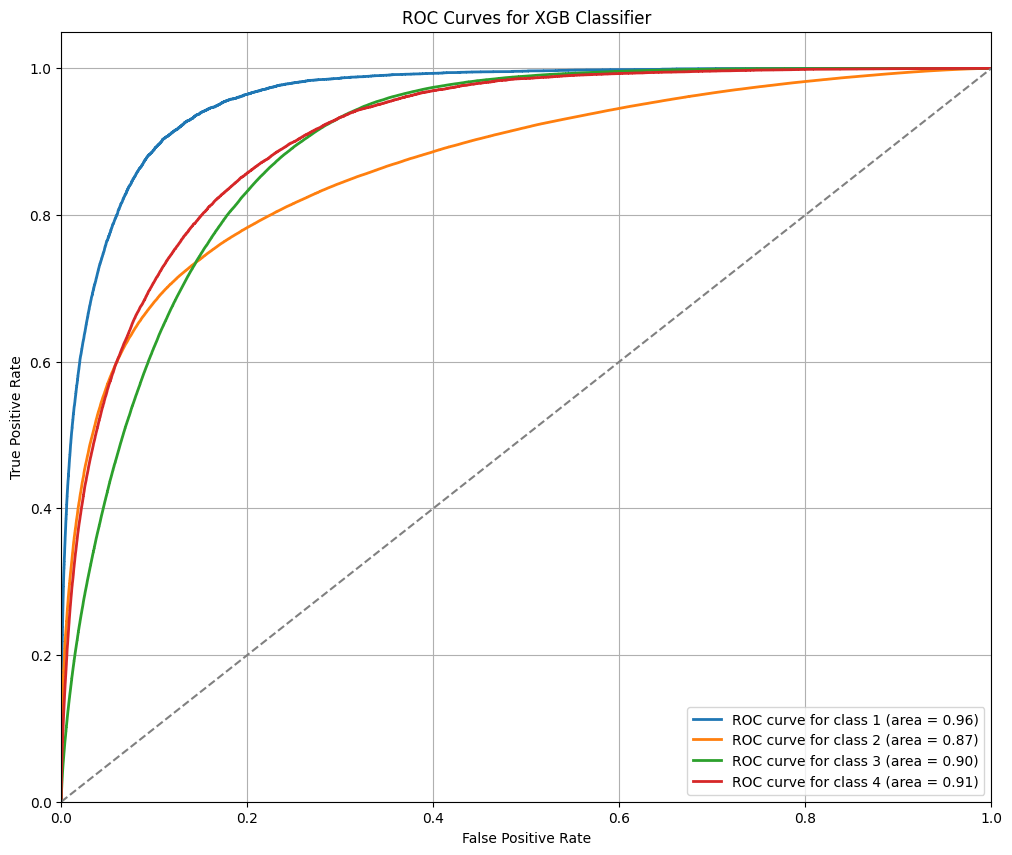

XGB Classifier Accuracy: 0.7716

Classification Report:
              precision    recall  f1-score   support

           1       0.39      0.38      0.39      9362
           2       0.94      0.77      0.85    873568
           3       0.46      0.83      0.60    188164
           4       0.34      0.37      0.35     27219

    accuracy                           0.77   1098313
   macro avg       0.53      0.59      0.55   1098313
weighted avg       0.84      0.77      0.79   1098313



C:\Users\amrut\AppData\Local\Temp\ipykernel_18576\3489665480.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')


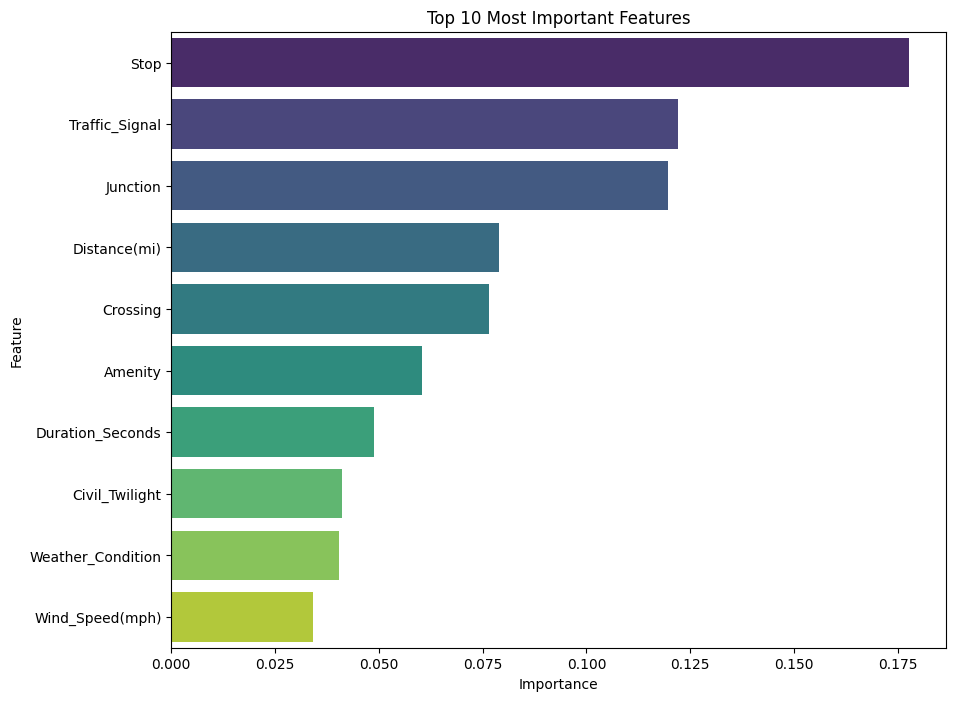

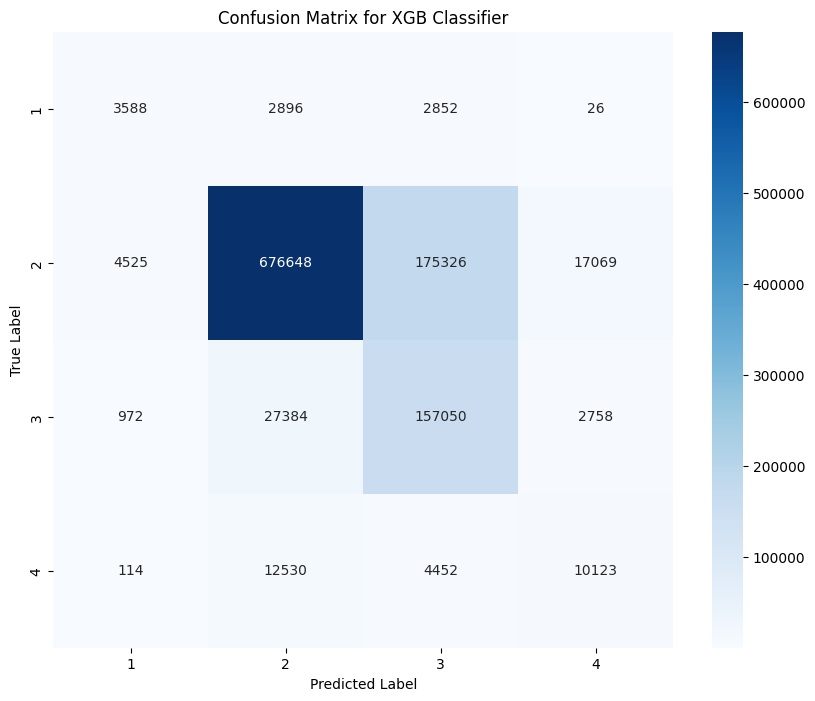

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("Train_Set.csv")
val_data = pd.read_csv("Validation_Set.csv")
test_data = pd.read_csv('Test_Set.csv')

X_train = train_data.drop(columns=["Severity"])
y_train = train_data["Severity"]

X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

combined_data = pd.concat([train_data, val_data], axis=0)
X_combined = combined_data.drop(columns=["Severity"])
y_combined = combined_data["Severity"]

# Create an indicator array for the validation set split
split_index = [-1] * len(train_data) + [0] * len(val_data)
predefined_split = PredefinedSplit(test_fold=split_index)

xgb_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1, 0.2],
    'max_depth': [7, 10, 20],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.6, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'gamma': [0.1, 0.5, 1],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}

model_xgb_cv = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    param_distributions= xgb_params,
    cv= predefined_split,
    n_iter= 25,
    n_jobs= 1,
    verbose=2,
    error_score='raise',
    scoring= 'neg_mean_squared_error'
)

y_combined_adjusted = y_combined - 1

model_xgb_cv.fit(X_combined, y_combined_adjusted)

best_model_xgb = model_xgb_cv.best_estimator_
print("Best parameters for XGB Classifier: ", model_xgb_cv.best_params_)

y_pred = best_model_xgb.predict(X_test)

y_pred_adjusted = y_pred + 1

classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Get probabilities for the ROC curve (required for AUC calculation)
y_prob = best_model_xgb.predict_proba(X_test)

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGB Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()


accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f"XGB Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Feature Importance
importances = best_model_xgb.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to see feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_10_features = importance_df.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGB Classifier')
plt.show()
